In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style="whitegrid", palette="muted", font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# Random_seed, labels 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]



In [72]:
data = pd.read_csv("/Users/jk/git/Study/Data/kaggle_dataset/credit_fraud/creditcard.csv")
data.shape

(284807, 31)

In [73]:
data.isnull().sum().any()

False

Text(0, 0.5, 'Frequency')

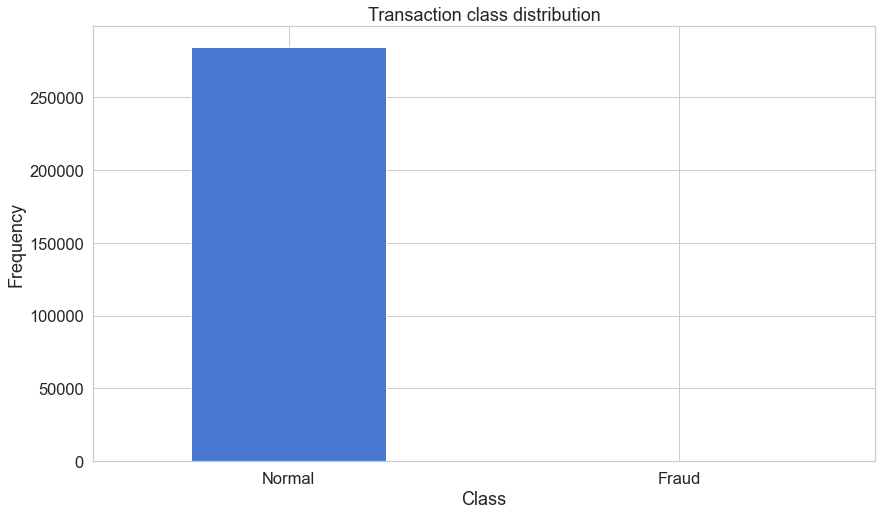

In [77]:
count_classes = data["Class"].value_counts(sort=True)
count_classes.plot(kind="bar", rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [30]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [31]:
fraud_data = data[data.Class == 1]
normal_data = data[data.Class == 0]
fraud_data.shape

(492, 31)

In [32]:
fraud_data.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [33]:
normal_data.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

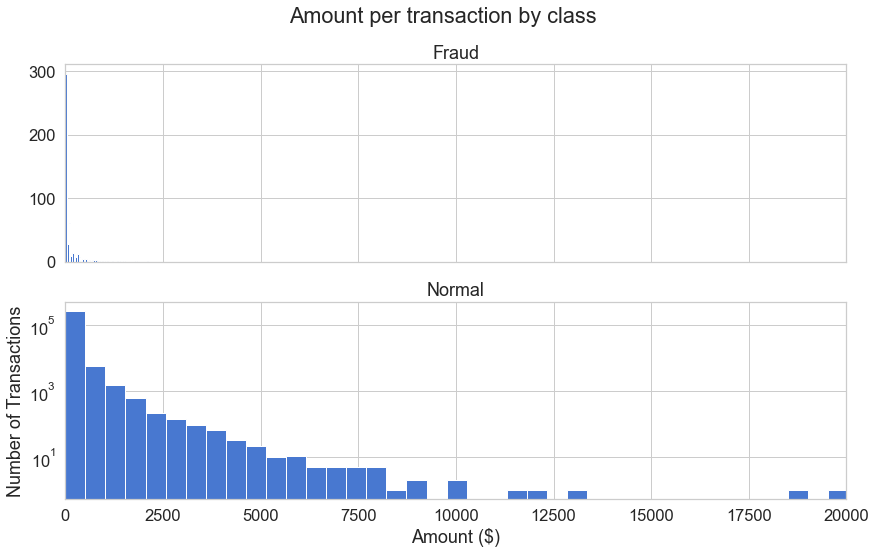

In [34]:
f, axes = plt.subplots(2, 1, sharex=True)
f.suptitle("Amount per transaction by class")

bins = 50

axes[0].hist(fraud_data.Amount, bins=bins)
axes[0].set_title("Fraud")

axes[1].hist(normal_data.Amount, bins=bins)
axes[1].set_title("Normal")

plt.xlabel("Amount ($)")
plt.ylabel("Number of Transactions")
plt.xlim((0, 20000))
plt.yscale("log")
plt.show()

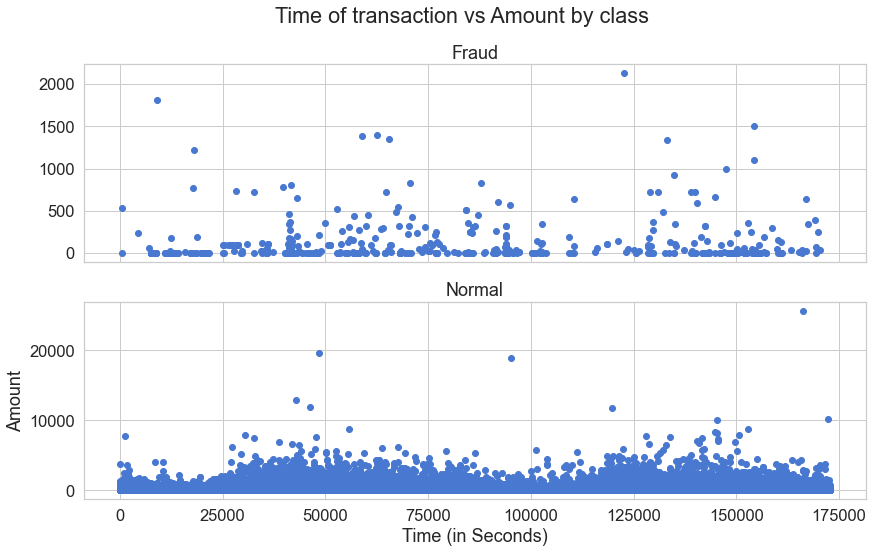

In [35]:
f, axes = plt.subplots(2, 1, sharex=True)
f.suptitle("Time of transaction vs Amount by class")

axes[0].scatter(x=fraud_data.Time, y=fraud_data.Amount)
axes[0].set_title("Fraud")

axes[1].scatter(x=normal_data.Time, y=normal_data.Amount)
axes[1].set_title("Normal")

plt.xlabel("Time (in Seconds)")
plt.ylabel("Amount")
plt.show()

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [37]:
from sklearn.preprocessing import StandardScaler

data = data.drop(["Time"], axis=1)

data["Amount"] = StandardScaler().fit_transform(data["Amount"].values.reshape(-1, 1))

In [38]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
train = train[train.Class==0]
train = train.drop(["Class"], axis=1)

test_label = test.pop("Class")

train = train.values
test = test.values

train.shape

(227451, 29)

In [39]:
input_dim = train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
               activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
decoder = Dense(input_dim, activation="relu")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [41]:
nb_epoch = 100
batch_size = 32
filepath_ck = "model_{epoch}"
log_dir = "./logs"

autoencoder.compile(optimizer="adam",
                   loss="mean_squared_error",
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=filepath_ck,
                              verbose=1,
                               monitor="val_loss",
                               save_best_only=True)

tensorboard = TensorBoard(log_dir=log_dir,
                         histogram_freq=0,
                         write_graph=True,
                         write_images=True)

history = autoencoder.fit(train, train,
                         epochs=nb_epoch,
                         batch_size=batch_size,
                         shuffle=True,
                         validation_data=(test, test),
                         verbose=1,
                         callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 21s 900us/step - loss: 0.8618 - accuracy: 0.5028 - val_loss: 0.8000 - val_accuracy: 0.6512

Epoch 00001: val_loss improved from inf to 0.79997, saving model to model_1
INFO:tensorflow:Assets written to: model_1/assets
Epoch 2/100
7108/7108 [==============================] - 6s 826us/step - loss: 0.7492 - accuracy: 0.6535 - val_loss: 0.7816 - val_accuracy: 0.6679

Epoch 00002: val_loss improved from 0.79997 to 0.78165, saving model to model_2
INFO:tensorflow:Assets written to: model_2/assets
Epoch 3/100
7108/7108 [==============================] - 6s 833us/step - loss: 0.7570 - accuracy: 0.6711 - val_loss: 0.7735 - val_accuracy: 0.6854

Epoch 00003: val_loss improved from 0.78165 to 0.77353, saving model to model_3
INFO:tensorflow:Assets written to: model_3/assets
Epoch 4/100
7108/7108 [==============================] - 6s 848us/step - loss: 0.7425 - accuracy: 0.6833 - val_loss: 0.7700 - val_accuracy: 0.6913

Epoch 00004: val_loss

7108/7108 [==============================] - 6s 896us/step - loss: 0.7184 - accuracy: 0.7204 - val_loss: 0.7419 - val_accuracy: 0.7225

Epoch 00033: val_loss did not improve from 0.74166
Epoch 34/100
7108/7108 [==============================] - 6s 837us/step - loss: 0.7031 - accuracy: 0.7203 - val_loss: 0.7482 - val_accuracy: 0.7190

Epoch 00034: val_loss did not improve from 0.74166
Epoch 35/100
7108/7108 [==============================] - 6s 839us/step - loss: 0.7163 - accuracy: 0.7219 - val_loss: 0.7416 - val_accuracy: 0.7228

Epoch 00035: val_loss improved from 0.74166 to 0.74165, saving model to model_35
INFO:tensorflow:Assets written to: model_35/assets
Epoch 36/100
7108/7108 [==============================] - 6s 843us/step - loss: 0.7089 - accuracy: 0.7209 - val_loss: 0.7425 - val_accuracy: 0.7235

Epoch 00036: val_loss did not improve from 0.74165
Epoch 37/100
7108/7108 [==============================] - 6s 904us/step - loss: 0.7113 - accuracy: 0.7216 - val_loss: 0.7430 - val_a

7108/7108 [==============================] - 6s 877us/step - loss: 0.7076 - accuracy: 0.7230 - val_loss: 0.7489 - val_accuracy: 0.7050

Epoch 00072: val_loss did not improve from 0.74078
Epoch 73/100
7108/7108 [==============================] - 6s 842us/step - loss: 0.7005 - accuracy: 0.7233 - val_loss: 0.7413 - val_accuracy: 0.7234

Epoch 00073: val_loss did not improve from 0.74078
Epoch 74/100
7108/7108 [==============================] - 6s 850us/step - loss: 0.7009 - accuracy: 0.7260 - val_loss: 0.7409 - val_accuracy: 0.7303

Epoch 00074: val_loss did not improve from 0.74078
Epoch 75/100
7108/7108 [==============================] - 6s 914us/step - loss: 0.7011 - accuracy: 0.7225 - val_loss: 0.7414 - val_accuracy: 0.7262

Epoch 00075: val_loss did not improve from 0.74078
Epoch 76/100
7108/7108 [==============================] - 6s 895us/step - loss: 0.7177 - accuracy: 0.7237 - val_loss: 0.7405 - val_accuracy: 0.7260

Epoch 00076: val_loss improved from 0.74078 to 0.74049, saving m

In [44]:
autoencoder = load_model("model_93")

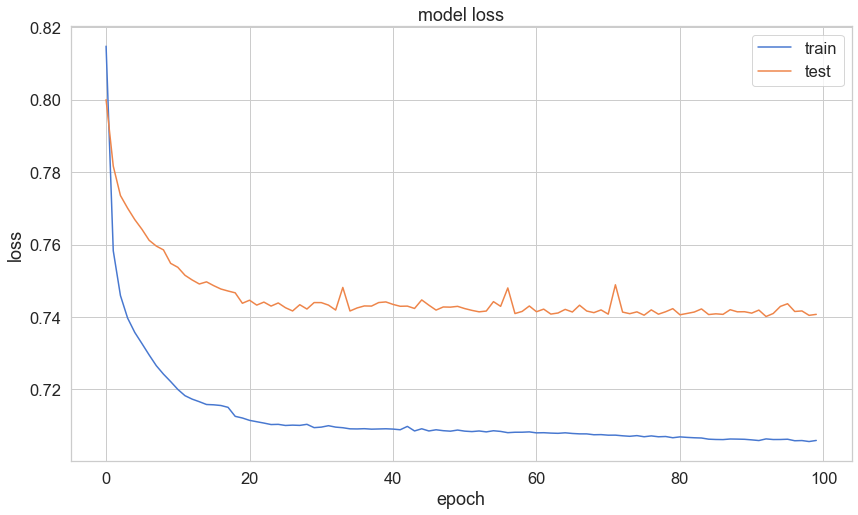

In [47]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc="upper right")

In [49]:
predictions = autoencoder.predict(test)
mse = np.mean(np.power(test - predictions, 2), axis=1)
error_df = pd.DataFrame({"reconstruction_error": mse,
                        "true_class": test_label})

error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.739212,0.001720
std,3.395099,0.041443
min,0.045294,0.000000
25%,0.239819,0.000000
50%,0.381905,0.000000
75%,0.612452,0.000000
max,254.950610,1.000000


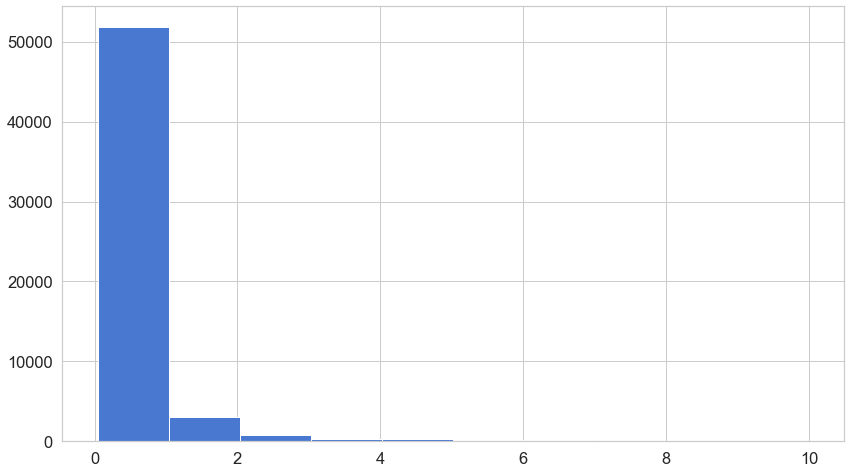

In [54]:
# fig.add_subplot(111) = fig.add_subplot(1, 1, 1) 
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

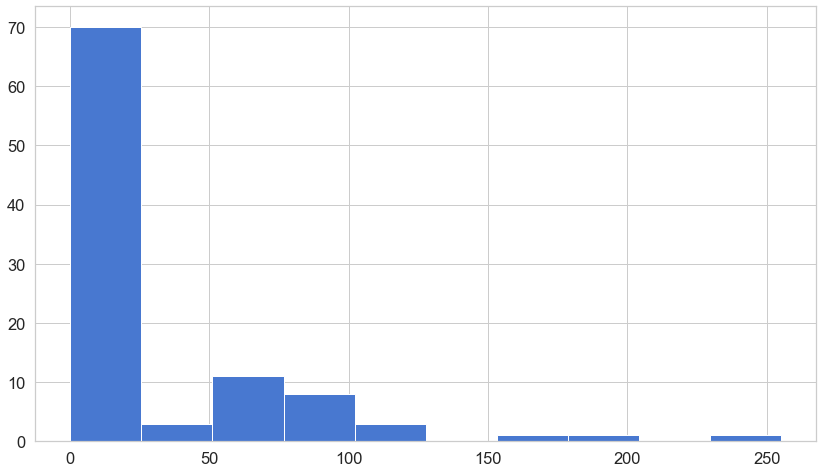

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [57]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, 
                             roc_curve, recall_score, classification_report, 
                             f1_score, precision_recall_fscore_support)

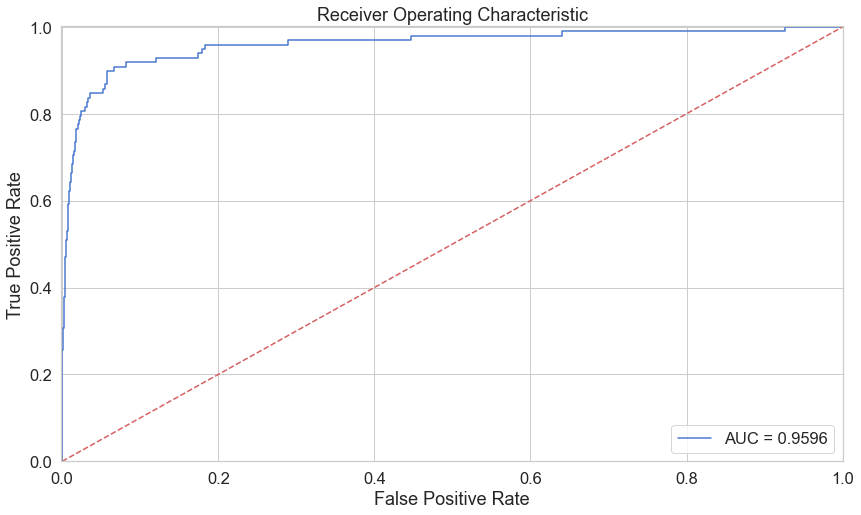

In [59]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:0.4f}')
plt.legend(loc="lower right")
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

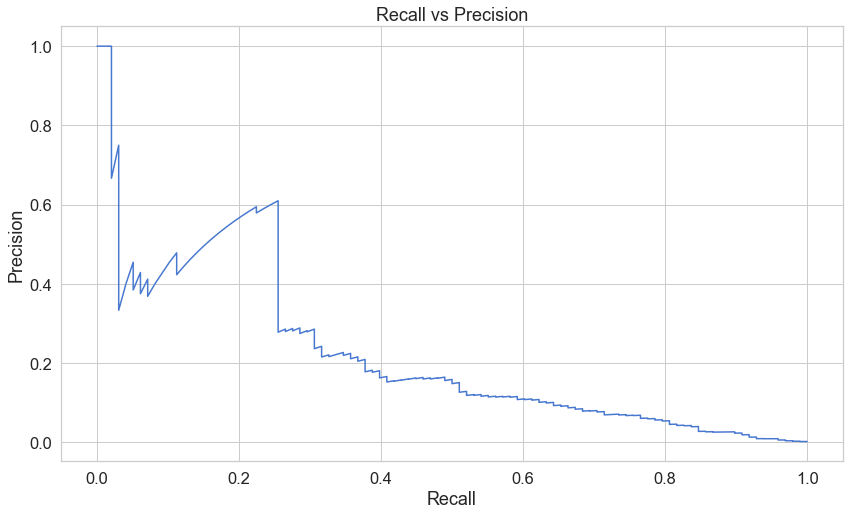

In [61]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label="Precision-Recall curve")
plt.title("Recall vs Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

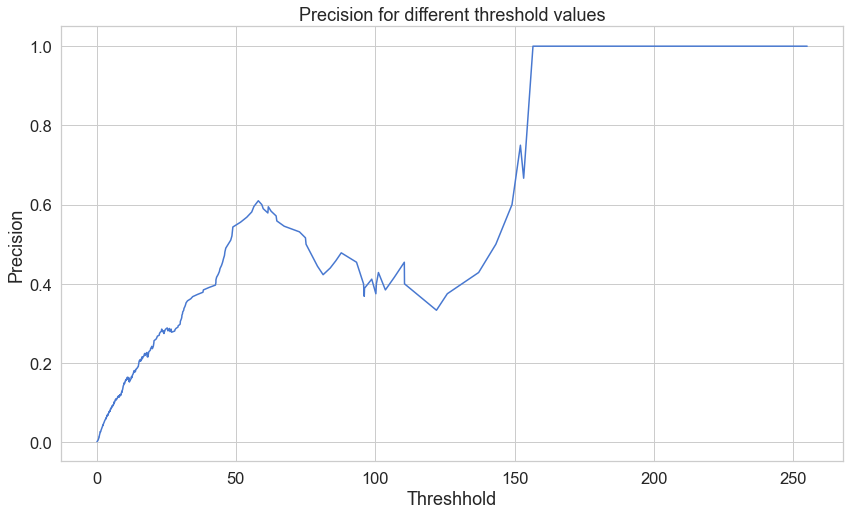

In [68]:
plt.plot(th, precision[1:], 'b', label="Threshold-Precision curve")
plt.title("Precision for different threshold values")
plt.xlabel("Threshhold")
plt.ylabel("Precision")
plt.show()

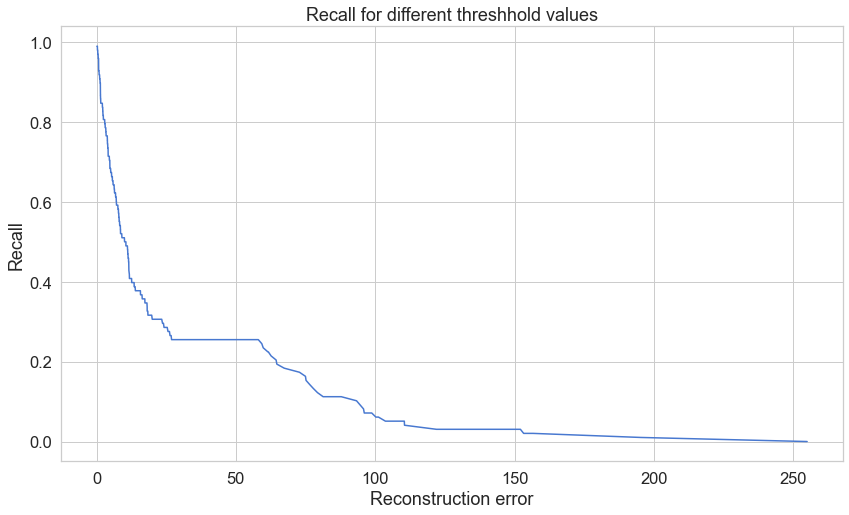

In [65]:
plt.plot(th, recall[1:], 'b', label="Threshold-Recall curve")
plt.title("Recall for different threshold values")
plt.xlabel("Reconstruction error")
plt.ylabel("Recall")
plt.show()

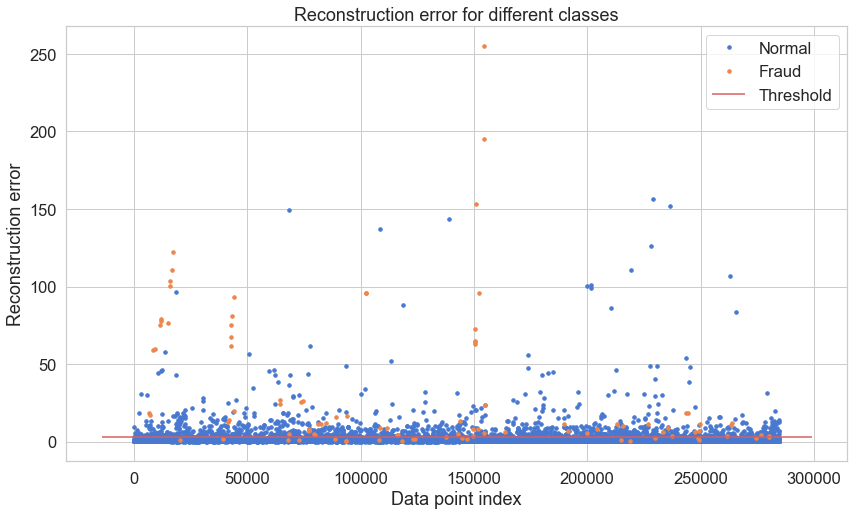

In [69]:
threshold = 2.9

groups = error_df.groupby("true_class")
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker="o", ms=3.5, linestyle='',
           label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label="Threshold")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

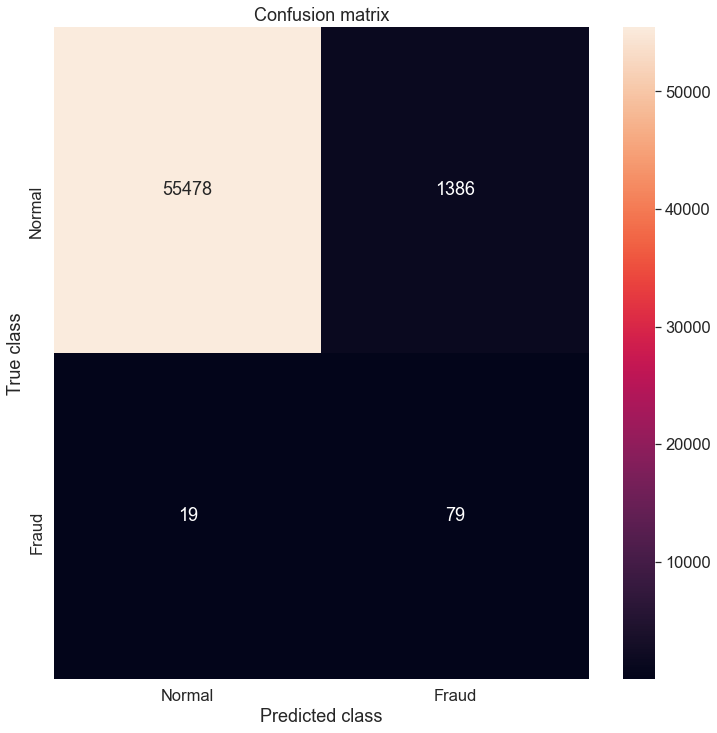

In [70]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()